# Mining Personal Traits in Social Media

**SIAM SDM 2016 Tutorial**

[Aron Culotta](http://www.cs.iit.edu/~culotta/)  (Illinois Inst. of Technology) and [Dongwon Lee](http://nike.psu.edu/dongwon/) (Penn State) 

Below we demonstrate the approach of Culotta et al. ["Predicting Twitter User Demographics using Distance Supervision from Website Traffic Data"](http://tapilab.github.io/user%20attribute%20inference/2016/02/01/predicting)

This uses aggregate demographics (from Quantcast.com) to build a model that is then applied at the user level.

See a companion notebook to the original paper [here](https://github.com/tapilab/jair-2016-demographics/blob/master/README.md).

The data is available here:
https://www.dropbox.com/sh/4bmfw2e3kktoz17/AACOJ_79eeEosIG8h4DQaSfba?dl=0

Please email Aron for the password.

In [1]:
# imports
from collections import Counter
import gzip
import matplotlib.pyplot as plt
from numpy import array as npa
import pandas as pd
from pprint import pprint
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import MultiTaskElasticNet, Ridge
from sklearn.preprocessing import normalize, scale
from sklearn.metrics import classification_report
from twutil import collect

%matplotlib inline
plt.style.use('ggplot')

data_path = 'data'

## Read Quantcast data.

In [2]:
quantcast_df = pd.read_csv(data_path + '/quantcast.tsv', sep='\t')
quantcast_df.head(10)

,twitter_id,twitter_handle,Democrat,Republican,No College,College,Grad School,No Kids,Has Kids,$0-50k,...,18-24,25-34,35-44,45-54,55-64,65+,Caucasian,Hispanic,African American,Asian
0,15650816,broadwayworld,38.0,16.0,30.0,48.0,22.0,63.0,37.0,49.0,...,14.0,21.0,17.0,18.0,11.0,5.0,81.0,7.0,7.0,4.0
1,108021761,valuewalk,25.0,21.0,26.0,45.0,29.0,46.0,54.0,36.0,...,11.0,26.0,25.0,15.0,8.0,5.0,66.0,10.0,7.0,16.0
2,15736836,pbpost,35.0,20.0,34.0,48.0,17.0,55.0,45.0,42.0,...,8.0,16.0,20.0,22.0,11.0,8.0,76.0,9.0,12.0,2.0
3,17448965,RiverfrontTimes,30.0,17.0,22.0,51.0,27.0,58.0,42.0,42.0,...,12.0,24.0,21.0,18.0,10.0,4.0,86.0,4.0,6.0,3.0
4,21237766,GameZoneOnline,23.0,21.0,53.0,40.0,8.0,47.0,53.0,70.0,...,27.0,25.0,15.0,8.0,1.0,1.0,74.0,13.0,7.0,4.0
5,26585095,nbc,31.0,24.0,36.0,47.0,17.0,50.0,50.0,54.0,...,12.0,20.0,18.0,17.0,10.0,3.0,78.0,9.0,8.0,4.0
6,15165450,NewsOn6,27.0,39.0,40.0,49.0,11.0,44.0,56.0,54.0,...,9.0,18.0,22.0,22.0,8.0,4.0,76.0,14.0,7.0,2.0
7,890891,BleacherReport,30.0,24.0,36.0,46.0,18.0,51.0,49.0,41.0,...,11.0,21.0,23.0,17.0,9.0,6.0,74.0,10.0,11.0,4.0
8,14571534,alphamom,36.0,23.0,20.0,52.0,28.0,31.0,69.0,38.0,...,10.0,34.0,23.0,9.0,6.0,2.0,82.0,8.0,5.0,4.0
9,25589776,peoplemag,37.0,24.0,29.0,51.0,19.0,47.0,53.0,41.0,...,8.0,23.0,24.0,20.0,9.0,3.0,83.0,8.0,5.0,3.0


## Read neighbor counts.


The file `followers.tsv.gz` looks like this:
```
15650816	76611584:2	8519682:1	419168262:2 ...
```
where the first element is the Twitter id of a website,  
and each additional element is a `<Twitter_id, count>` tuple  
indicating the number of followers of this webiste that follow this other account.

## Preprocessing and model fitting.

In [3]:
"""
Here is a wrapper class to perform the preprocessing, training, and classification.
"""
class NeighborClassifier:
    
    def preprocess(self, followers_file):
        """Read the followers file into a sparse matrix."""
        self.brand_ids = []
        self.vectorizer = DictVectorizer()
        self.Xtrain = self.vectorizer.fit_transform(counts for brand_id, counts in
                                                    self._iterate_neighbor_counts(followers_file)
                                                    if not self.brand_ids.append(brand_id))
        plot_neighbor_counts(self.Xtrain)
        self.Xtrain = normalize(self.Xtrain, norm='l1', axis=1)    
        print('neighbor feature matrix has shape %s' % str(self.Xtrain.shape))
                        
            
    def _iterate_neighbor_counts(self, fname):
        """Read dict from twitter id to second-degree neighbor counts.
        Format: <twitter id> <twitter id>:<count> <twitter id>:<count> ...
        where first id is for website account, and the rest are accounts
        that followers of the website account also follow."""
        fh = gzip.open(fname, 'rt')
        results = {}
        for line in fh:
            parts = line.split('\t')   
            yield (int(parts[0]), dict([(int(part.split(':')[0]),
                                         int(part.split(':')[1]))for part in parts[1:]]))


    def train_from_df(self, quantcast_df, categories):
        """
        Fit a regression model to quantcast statistics, using self.Xtrain.
        """
        self.categories = categories
        self.models = {}
        for category, labels in categories.items():
            print('fitting model for %s' % category)
            indices, y = self._select_instances(self.brand_ids, quantcast_df, labels)
            X = self.Xtrain[indices]
            print('%d training instances' % X.shape[0])
            model = self._get_model()
            model.fit(X.toarray(), y)  # ElasticNet requires dense matrix!!!
            self.models[category] = self._reg_to_classify(model)
            
    def _get_model(self):
        return MultiTaskElasticNet(alpha=1e-5, l1_ratio=0.5)

    def _reg_to_classify(self, model):
        """ z-score coefficients, set intercept to 0, and put in a ridge model. """
        ridge = Ridge()
        ridge.coef_ = scale(model.coef_, axis=1)
        ridge.intercept_ = 0
        return ridge
    
    
    def _select_instances(self, twitter_ids, quantcast_df, labels):
        """ Return indices in quantcast_df that have non-NA values for the given columns"""
        indices = []
        yvals = []
        for index, id_ in enumerate(twitter_ids):
            if len(labels) == quantcast_df[quantcast_df.twitter_id==id_][labels].count().sum():
                # we have demographics for this website.
                indices.append(index)
                yvals.append(npa(quantcast_df[quantcast_df.twitter_id==id_][labels])[0])
        return indices, npa(yvals)
        
    def classify(self, friend_list):
        """Classify a single user based on a list of friend ids."""
        newX = self.vectorizer.transform([Counter([int(x) for x in friend_list])])
        prediction = {}
        for category, model in self.models.items():
            prediction[category] = dict(zip(self.categories[category], model.predict(newX)[0]))
        return prediction
    

def plot_neighbor_counts(X):
    """ Plot stats of followers from sparse matrix. """
    figure, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
    unique_friends = sorted([xi.nnz for xi in X], reverse=True)
    axes[0].plot(unique_friends)
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_title('number of unique neighbors', size=16)

    brcounts = sorted([xi.sum() for xi in X], reverse=True)
    print('total friend links:', sum(brcounts))
    axes[1].plot(brcounts)
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_title('number of neighbor links', size=16)
    axes[1].set_xlim((0,1500))
    axes[0].set_xlabel('rank', size=16)
    axes[1].set_xlabel('rank', size=16)
    axes[0].set_ylabel('count', size=16)
    axes[1].set_ylabel('count', size=16)
    figure.tight_layout()

total friend links: 177997246.0
neighbor feature matrix has shape (1072, 46649)


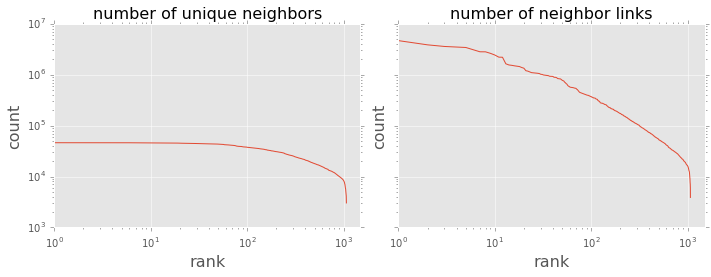

In [4]:
neighbor_classifier = NeighborClassifier()
neighbor_classifier.preprocess(data_path + '/followers.tsv.gz')

In [5]:
categories = {'Politics': ['Democrat', 'Republican'],
              'Education': ['No College', 'College', 'Grad School'],
              'Children': ['No Kids', 'Has Kids'],
              'Income': ['$0-50k', '$50-100k', '$100-150k', '$150k+'],
              'Gender': ['Male', 'Female'],
              'Age': ['18-24', '25-34', '35-44', '45-54', '55-64', '65+'],
              'Ethnicity': ['Caucasian', 'Hispanic', 'African American', 'Asian']}

In [6]:
neighbor_classifier.train_from_df(quantcast_df, categories)

fitting model for Education
1046 training instances
fitting model for Politics
957 training instances
fitting model for Age
1072 training instances
fitting model for Gender
1066 training instances
fitting model for Ethnicity
1035 training instances
fitting model for Children
1052 training instances
fitting model for Income
1043 training instances


## Now classify pre-annotated users

We next read in a text file of labeled users in the format:

```
<Twitter id or handle> <label> <list of friends>
```

In [7]:
# Gender data comes from Aron Culotta and Ehsan Ardehaly. 
!head -1 data/gender.txt | cut -c-80

prettygiirl_ri Female 973944740 576890292 929766590 2752790981 307589294 1527956


In [8]:
# Politics data comes from Svitlana Volkova.
# http://www.cs.jhu.edu/~svitlana/data/data_collection.pdf
# This is the "geo-centric" data, where users self identify in description.
!head -1 data/politics.txt | cut -c-80

243060741 Democrat 15912890 3048165698 18140340 2360061992 3026127280 387562192 


In [9]:
# Read labeled data.
def read_labeled_with_friends(fname):
    return [line.split() for line in open(fname)]

In [10]:
# For example, classify the first line in politics.txt.
pprint(neighbor_classifier.classify(read_labeled_with_friends(data_path + '/politics.txt')[0][2:]))

{'Age': {'18-24': -278.7676605260296,
         '25-34': -140.13290390016525,
         '35-44': 141.37606382159211,
         '45-54': 331.20559708226455,
         '55-64': 354.03173350895014,
         '65+': 387.41832484300556},
 'Children': {'Has Kids': -450.31863667484504, 'No Kids': 450.31863667484504},
 'Education': {'College': 190.72580710697741,
               'Grad School': 777.16334208324508,
               'No College': -626.36258636294724},
 'Ethnicity': {'African American': -204.03958354111944,
               'Asian': 56.241653391721442,
               'Caucasian': 238.73922217789473,
               'Hispanic': -278.37419743585235},
 'Gender': {'Female': -85.529655431025986, 'Male': 85.529655431025986},
 'Income': {'$0-50k': -409.4057729847882,
            '$100-150k': 394.5569412931336,
            '$150k+': 535.91798855816569,
            '$50-100k': 184.23681385327075},
 'Politics': {'Democrat': 99.203521150495263,
              'Republican': -144.66509342125366}}


In [11]:
def classify_file(fname, category, classifier):
    """
    Read in a labeled data file, vectorize, classify, and print accuracy.
    """
    labeled_data = read_labeled_with_friends(fname)
    preds_all = [neighbor_classifier.classify(f[2:]) for f in labeled_data]
    preds = get_predicted_labels(category, preds_all)
    trues = [f[1] for f in labeled_data]
    print('predicted class distribution:%s' % str(Counter(preds)))
    print(classification_report(trues, preds))    

def get_predicted_labels(category, preds):
    """ Return the highest posterior prediction for this category. """
    result = []
    for pred in preds:
        keys = list(pred[category].keys())
        result.append(keys[npa(list(pred[category].values())).argmax()])
    return result

In [12]:
classify_file(data_path + '/gender.txt', 'Gender', neighbor_classifier)

predicted class distribution:Counter({'Female': 114, 'Male': 100})
             precision    recall  f1-score   support

     Female       0.86      0.77      0.81       127
       Male       0.71      0.82      0.76        87

avg / total       0.80      0.79      0.79       214



In [13]:
classify_file(data_path + '/politics.txt', 'Politics', neighbor_classifier)

predicted class distribution:Counter({'Democrat': 239, 'Republican': 127})
             precision    recall  f1-score   support

   Democrat       0.80      0.92      0.85       208
 Republican       0.87      0.70      0.77       158

avg / total       0.83      0.82      0.82       366



## Finally, test out on known users...

In [14]:
def fetch_and_classify(screen_name, classifier):
    friends = collect.get_friends(screen_name=screen_name)
    pprint(classifier.classify(friends))

In [15]:
fetch_and_classify('realDonaldTrump', neighbor_classifier)

fetched 40 more friends for realDonaldTrump


{'Age': {'18-24': -66.897966455022214,
         '25-34': -84.760112134270514,
         '35-44': -18.144623119543564,
         '45-54': 82.789665969872999,
         '55-64': 93.656637977422477,
         '65+': 115.63631208589219},
 'Children': {'Has Kids': -13.95507408877878, 'No Kids': 13.95507408877878},
 'Education': {'College': -3.2789304471321654,
               'Grad School': 23.718267721266105,
               'No College': -14.952693219780731},
 'Ethnicity': {'African American': -16.813032744780205,
               'Asian': -51.327144935307395,
               'Caucasian': 38.495079186139584,
               'Hispanic': -49.529687419022551},
 'Gender': {'Female': -24.75579649246302, 'Male': 24.75579649246302},
 'Income': {'$0-50k': -46.718362970338781,
            '$100-150k': 47.529908800314345,
            '$150k+': 38.784872960005913,
            '$50-100k': 41.706777677136955},
 'Politics': {'Democrat': -74.053708452268438,
              'Republican': 104.24526497466996}}


In [16]:
fetch_and_classify('HillaryClinton', neighbor_classifier)

fetched 651 more friends for HillaryClinton


{'Age': {'18-24': -20.675608920927431,
         '25-34': 2.8504142168773372,
         '35-44': 63.28123863181915,
         '45-54': 13.530722043311624,
         '55-64': -11.467819882734897,
         '65+': -29.666935263068943},
 'Children': {'Has Kids': -41.042654373877347, 'No Kids': 41.042654373877347},
 'Education': {'College': 1.2283372153516099,
               'Grad School': 30.185701515556065,
               'No College': -21.252700160691507},
 'Ethnicity': {'African American': 98.490836827204689,
               'Asian': -87.283737424703716,
               'Caucasian': -62.636783989739612,
               'Hispanic': 5.2601230274163759},
 'Gender': {'Female': 160.26322589310774, 'Male': -160.26322589310774},
 'Income': {'$0-50k': 68.941243693964964,
            '$100-150k': -77.604578996062727,
            '$150k+': -61.409146696407674,
            '$50-100k': -51.412367411783798},
 'Politics': {'Democrat': 235.45190647413907, 'Republican': -138.0692717275081}}


In [17]:
fetch_and_classify('aronwc', neighbor_classifier)

fetched 57 more friends for aronwc


{'Age': {'18-24': -4.6859816123765548,
         '25-34': 4.6567416606835783,
         '35-44': 7.6242747697732627,
         '45-54': 1.662120750908384,
         '55-64': 2.3103745286922313,
         '65+': 3.3375137727319792},
 'Children': {'Has Kids': -11.423431564572809, 'No Kids': 11.423431564572809},
 'Education': {'College': 5.8620360037217427,
               'Grad School': 18.116010432466499,
               'No College': -15.223107870813338},
 'Ethnicity': {'African American': -2.4105745445350055,
               'Asian': 1.3324946569191798,
               'Caucasian': 3.9112992208005308,
               'Hispanic': -7.5448833610176704},
 'Gender': {'Female': -5.2972243544545394, 'Male': 5.2972243544545394},
 'Income': {'$0-50k': -9.3263435901322076,
            '$100-150k': 8.5996902025506756,
            '$150k+': 12.341958092099979,
            '$50-100k': 4.5839174352466188},
 'Politics': {'Democrat': 8.2046172412955691,
              'Republican': -8.3901901329633226}}


In [18]:
# Aron is not very active on Twitter, so the prediction
# is based on only two accounts.

# get who aron follows.
aron_friends = collect.get_friends(screen_name='aronwc')
# transform to feature matrix.
aronX = neighbor_classifier.vectorizer.transform([Counter([int(x) for x in aron_friends])])
# lookup the Twitter ids for the non-zero indices.
ids = npa(neighbor_classifier.vectorizer.get_feature_names())[aronX.indices]
collect.lookup_handles(ids)

fetched 57 more friends for aronwc


{('NateSilver538', '16017475'), ('monkeycageblog', '116630713')}

** See the [JAIR replication notebook](https://github.com/tapilab/jair-2016-demographics/blob/master/README.md) for additional models using text features. **